This nb tries to solve 1-d swe dam -break using examples from pyclaw

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from time import time

import sys
from clawpack import pyclaw
import h5py as h5
import pickle

In [2]:
sys.path.append('/Users/rajvanmp/k@ust_learn/TF_PINNs')

In [3]:
from PINNs import PINN
DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)
pi = tf.constant(np.pi,dtype=DTYPE)


In [4]:
class domain():
    def __init__(self,lower,upper,DTYPE):
        self.lwb = tf.constant(lower,dtype=DTYPE)
        self.upb = tf.constant(upper,dtype=DTYPE)
        self.dim = tf.constant(len(lower))
        
    def sample_domain(self,n=10):
        x = []
        for i in range(self.dim):
            print(self.lwb[i],self.upb[i])
            x.append(tf.random.uniform((n,1),self.lwb[i],self.upb[i],dtype=DTYPE))
            
        return tf.squeeze(tf.stack(x,axis=1))
    
    def get_domain_points_lhs_1d(self,n=100):
    
        x_min = self.lwb[1].numpy()
        x_max = self.upb[1].numpy()
    
        t_min = self.lwb[0].numpy()
        t_max = self.upb[0].numpy()
    
        from scipy.stats import qmc
        sampler = qmc.LatinHypercube(d=2)
        sample = sampler.random(n)
        l_bounds = [t_min,x_min]
        u_bounds = [t_max,x_max]
        sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
        t = 1.0*sample_scaled[:,0]
        x = 1.0*sample_scaled[:,1]
    
    
    
        t = tf.constant(t,dtype=DTYPE)
        x = tf.constant(x,dtype=DTYPE)
    
        return tf.stack((t,x),axis=1)


In [5]:
def load_psi_hdf5(file_name,n,use_zeldo=1):
    f = h5.File(file_name,"r")
    keys = list(f.keys())
    if use_zeldo:
        psi = f["psi_zeldo"]
    else:
        psi = f["psi"]
        
    psi = psi[:,0]+1j*psi[:,1]
    psi = np.reshape(psi,(n,n,n))
        
    print("Psi shape",psi.shape,psi.dtype)
    
    return psi

def Hfunc(a,omega_m0,a0=1.0):
    return( np.sqrt(omega_m0*(a0/a)*(a0/a)*(a0/a) + (1.0 - omega_m0))    )

0.0007300306377927972


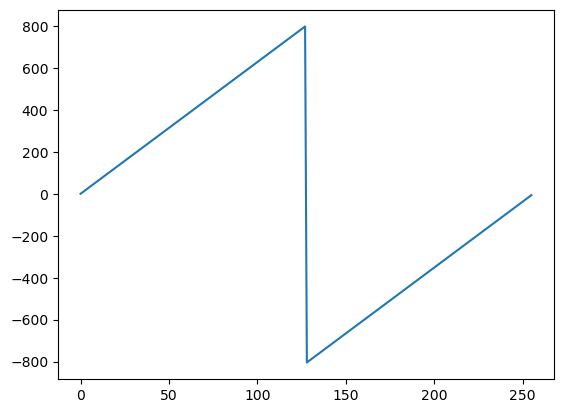

In [13]:
N = 256

L = 1.0
dx = tf.constant(L/N,dtype=DTYPE)
xi = np.fft.fftfreq(N)*N*2*np.pi/L
xi2 = (xi*xi)

c_unit = 2.99
hbar_unit = 6.582
pc_unit = 3.086
h = 0.67
m_alpha = 0.175
omega_m0 = 0.3
ai = 0.0078125
    
kppa = c_unit*c_unit*hbar_unit*h*0.00001/(m_alpha*pc_unit)
#psi_ini = load_psi_hdf5("/Users/rajvanmp/station_X/pyGP_fields/test_fdm_dt/dc_128_dc_theta_psi_zeldo.hdf5",128,1)
plt.plot(xi)
print(kppa)

In [14]:
def get_1dfrom3d(psi_i,along_axis=2,i0=20,i1=20):
    if along_axis==2:
        psi_ini = psi_i[i0,i1,:]
    if along_axis==1:
        psi_ini = psi_i[i0,:,i1]
    if along_axis==0:
        psi_ini = psi_i[:,i0,i1]
    
    psi_ini_r = np.real(psi_ini)
    psi_ini_i = np.imag(psi_ini)

    u2 = np.square(np.abs(psi_ini))
    vrhs = 0.5*(u2-np.mean(u2))/kppa
    dlt = (u2-np.mean(u2))/(3.0*omega_m0)
    vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
    vrhsft[0] = 0.0+0.0*1j
    V = (np.fft.ifftn(vrhsft,vrhsft.shape))/(ai*ai*Hfunc(ai,omega_m0));
    
    psiV = np.stack([psi_ini_r,psi_ini_i,V],axis=-1)
    
    print(psi_ini_r.shape,psi_ini_i.shape,V.shape,psiV.shape)
    
    
    
    x = tf.linspace(tf.constant(0.0,dtype=DTYPE),L,N)
    t = 0.0*tf.ones_like(x)
    
    d_ini = tf.stack([t,x],axis=-1)
    
    return d_ini,tf.constant(psiV,dtype=DTYPE)
    

def get_prd_on_ini(n,x_i,f_i):
    nby2= int(n/2.0)
    print("nby2",nby2)
    i1 = tf.random.uniform(shape=[nby2,],minval=-N,maxval=-1,dtype=tf.dtypes.int64)
    ig1 = ((N-1+i1)+N)%N
    i1f = tf.cast(i1,dtype=DTYPE)
    x1 = 0.0+i1f*dx
    f1 = tf.gather(f_i,ig1)
    
    
    i2 = tf.random.uniform(shape=[nby2,],minval=1,maxval=N-1,dtype=tf.dtypes.int64)
    i2f = tf.cast(i2,dtype=DTYPE)
    x2 = L+i2f*dx
    f2 = tf.gather(f_i,i2)
    
    x = tf.concat((x1,x2),axis=0)
    t = 0.0*tf.ones_like(x)
    f = tf.concat((f1,f2),axis=0)
    
    
    d = tf.stack((t,x),axis=-1)
    
    #print(i1.shape,x1.shape)
    #print(i2.shape,x2.shape)
    print(x.shape,d.shape)
    #plt.plot(x1)
    #plt.plot(x2)
    return d,f

def get_prd_dom(dom,n):
    a = tf.random.uniform((n,), dom.lwb[0], dom.upb[0], dtype=DTYPE)
    x = tf.random.uniform((n,), dom.lwb[1], dom.upb[1], dtype=DTYPE)
    brnli = tf.keras.backend.random_bernoulli((n,), 0.5, dtype=DTYPE)
    x2 = x + dom.upb[1]*brnli - (1.0-brnli)*dom.upb[1]
    print(dom.upb[1])
    return tf.stack((a,x,x2),axis=-1)
    

tf.Tensor(1.0, shape=(), dtype=float64)


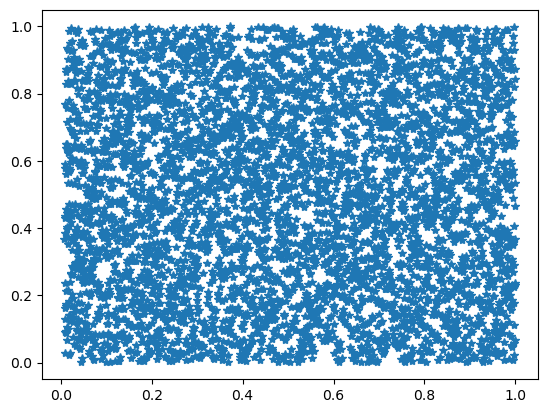

In [15]:
lower = (ai,0.0)
upper = (1.0,L)
dom = domain(lower,upper,DTYPE=DTYPE)
dom_bnds = [lower,upper]


x_prd =  get_prd_dom(dom,1024)

x_dom = dom.get_domain_points_lhs_1d(n=5000)

plt.plot(x_dom[:,0],x_dom[:,1],"*")

-1.3877787807814457e-17 0.00037508914544317633


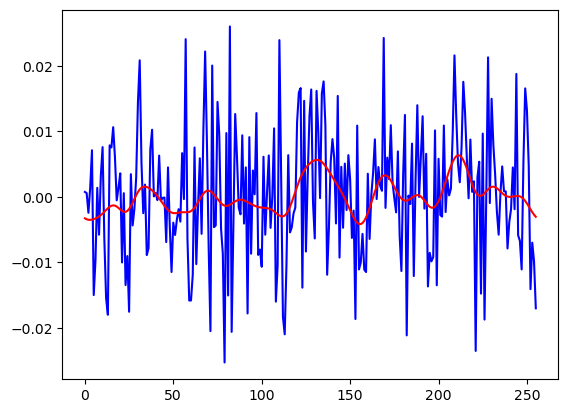

In [36]:
def pk(k,mu=0.0,sig = 10.5):
    return tf.exp(-tf.square((k-mu)/sig))

def ini_del(dom,n,pk,sigk):
    x = np.linspace(dom.lwb[1].numpy(),dom.upb[1].numpy(),n)
    mu = 0.0*np.ones([n,])
    sig = 0.01*np.ones([n,])
    u = np.random.normal(mu,sig)
    fu = np.fft.fftn(u,u.shape)
    
    kfac = np.sqrt(pk(xi,sig=sigk))
    fu = fu*kfac
    fu[0]=0.0+0.0j
    
    ifu =  np.real(np.fft.ifftn(fu,fu.shape))
    #ifu = 0.01*ifu/np.max(ifu)
    
    plt.plot(u,"b")
    plt.plot(ifu,"r")
    print(np.sum(ifu),np.mean(u))
    
    return ifu,np.square(kfac)

    
iu,kf = ini_del(dom,N,pk,50.0)

def ini_psiFromdel(ini_del,om,ai):
    psi_r = np.sqrt(1.0+ini_del)
    psi_r = np.sqrt(3.0*om)*psi_r
    psi_i = tf.zeros_like(psi_r)
    
    u2 = np.square(psi_r)+np.square(psi_i)
    vrhs = 0.5*(u2-np.mean(u2))/kppa
    dlt = (u2-np.mean(u2))/(3.0*om)
    vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
    vrhsft[0] = 0.0+0.0*1j
    V = (np.fft.ifftn(vrhsft,vrhsft.shape))/(ai*ai*Hfunc(ai,om));
    
    psiV = np.stack([psi_r,psi_i,V],axis=-1)
    
    print(psi_r.shape,psi_i.shape,V.shape,psiV.shape)
    
    
    
    x = tf.linspace(tf.constant(0.0,dtype=DTYPE),L,N)
    t = ai*tf.ones_like(x)
    
    d_ini = tf.stack([t,x],axis=-1)
    
    return d_ini,tf.constant(psiV,dtype=DTYPE)

def ini_psiVfrompsi(fp,om,ai):
    psi_ini = np.load(fp)
    psi_r = np.real(psi_ini)
   
    psi_i =  np.imag(psi_ini)
    
    u2 = np.square(psi_r)+np.square(psi_i)
    vrhs = 0.5*(u2-np.mean(u2))/kppa
    dlt = (u2-np.mean(u2))/(3.0*om)
    vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
    vrhsft[0] = 0.0+0.0*1j
    V = (np.fft.ifftn(vrhsft,vrhsft.shape))/(ai*ai*Hfunc(ai,om));
    
    psiV = np.stack([psi_r,psi_i,V],axis=-1)
    
    print(psi_r.shape,psi_i.shape,V.shape,psiV.shape)
    
    
    
    x = tf.linspace(tf.constant(0.0,dtype=DTYPE),L,N)
    t = ai*tf.ones_like(x)
    
    d_ini = tf.stack([t,x],axis=-1)
    
    return d_ini,tf.constant(psiV,dtype=DTYPE)
    
    

def plot_pk(u,pk):
    fu = np.fft.fftn(u,u.shape)
    fu2 = np.square(np.abs(fu))
    pkk = pk(xi)
    
    #plt.plot(xi,fu2,"r")
    #plt.plot(xi,pkk,"b")
    
#plot_pk(iu,pk)

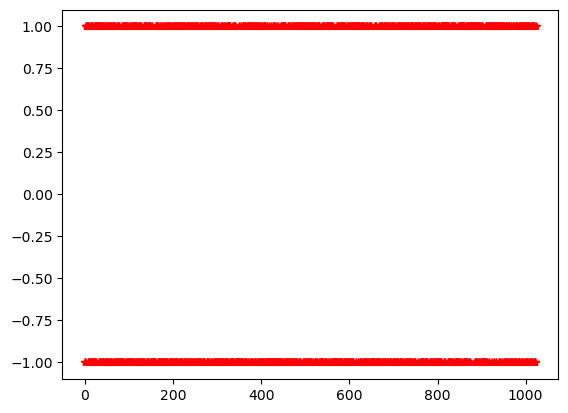

In [37]:
plt.plot(x_prd[:,1]-x_prd[:,2],"r*")


In [38]:
from PINNs import PINN

dlta = tf.constant([1e-6],dtype=DTYPE)


        

        



        
        
class SP1(PINN):
    def __init__(self,dom_bounds,out_scales,out_dim,prob_coef=None,DTYPE='float32'):
        super().__init__(dom_bounds,out_dim,prob_coef,DTYPE)
        self.omega_m0 = tf.constant(prob_coef[0],dtype=DTYPE)
        self.fmin = tf.constant(out_scales[0],dtype=DTYPE)
        self.fmax = tf.constant(out_scales[1],dtype=DTYPE)
        
    def Hfunc(self,a,a0=1.0):
        return( tf.sqrt(self.omega_m0*(a0/a)*(a0/a)*(a0/a) + (1.0 - self.omega_m0))    )   

    
    def periodic(self,dom_points):
        a,x1,x2 = dom_points[:,0:1],dom_points[:,1:2],dom_points[:,2:3]
        f1 = self.model(tf.stack((a[:,0],x1[:,0]),axis=1),training=True)
        f2 = self.model(tf.stack((a[:,0],x2[:,0]),axis=1),training=True)
        
        return f1-f2
    
    def diff_eqn(self,dom_points,a0=1.0):
        a,x = dom_points[:,0:1],dom_points[:,1:2]
        H = self.Hfunc(a)
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(a)
            tape.watch(x)
        
            f_un = self.model(tf.stack((a[:,0],x[:,0]),axis=1),training=True)
            f = 0.5*(f_un+1.0)*(self.fmax-self.fmin) +self.fmin
            
            psi_rl = f[:,0:1]
            psi_im = f[:,1:2]
            V = f[:,2:3]
            
            dx_psi_rl = tape.gradient(psi_rl,x)
            dx_psi_im = tape.gradient(psi_im,x)
            dx_V = tape.gradient(V,x)
            
         
            
        dxx_psi_rl = tape.gradient(dx_psi_rl,x)
        dxx_psi_im = tape.gradient(dx_psi_im,x)
        dxx_V = tape.gradient(dx_V,x)
        
        da_psi_rl = tape.gradient(psi_rl,a)
        da_psi_im = tape.gradient(psi_im,a)
        
        rhs_rl = -0.5*kppa*dxx_psi_im/(a*a*a*H) + V*psi_im/(a*a*H)
        rhs_im =  0.5*kppa*dxx_psi_rl/(a*a*a*H) - V*psi_rl/(a*a*H)
        rhs_V = 0.5*(tf.square(psi_im)+tf.square(psi_rl) - 3.0*self.omega_m0)

        del tape
        
        eqn1 = (da_psi_rl-rhs_rl)
        eqn2 = (da_psi_im-rhs_im)
        eqn3 = (dxx_V*kppa - rhs_V)
        #print(eqn1.shape,eqn2.shape)
        return tf.concat([eqn1,eqn2,eqn3],axis=1)  
    
    
    def compute_loss(self,dom_points,bndry_points,f_bndry,prd_dom):
        
        diff = self.diff_eqn(dom_points)
        diff_loss = tf.reduce_mean(tf.square(diff))
        
        prd = self.periodic(prd_dom)
        prd_loss = tf.reduce_mean(tf.square(prd))
    
        f_pred = self.model(bndry_points, training=True)
        bndry_loss = tf.reduce_mean(tf.square(f_pred-f_bndry))
    
        return bndry_loss+diff_loss+prd_loss,diff_loss/(bndry_loss+diff_loss)
    
    
    
    
    def get_loss_grads(self,dom_points,bndry_points,f_bndry,prd_dom):
        
        
       
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
        
            
            loss,diff_to_bndry = self.compute_loss(dom_points,bndry_points,f_bndry,prd_dom)
            
        
        grds = tape.gradient(loss,self.model.trainable_variables)
        
        del tape
        
        return loss,grds,diff_to_bndry
    
    
    @tf.function
    def train_step(self,dom_points,bndry_points,f_bndry,prd_dom):
        loss,grds,diff_to_bndry = self.get_loss_grads(dom_points,bndry_points,f_bndry,prd_dom)
        self.optim.apply_gradients(zip(grds, self.model.trainable_variables))
    
        return loss,diff_to_bndry
    
    
    def train(self,dom_points,bndry_points,f_bndry,prd_dom,n_epochs = 5000):
        
       	losses = []
        loss_min=tf.constant(1e6,dtype=self.DTYPE)
        param_best = self.model.get_weights()
        t0 = time()
        for i in range(n_epochs):
            loss,diff_to_loss = self.train_step(dom_points,bndry_points,f_bndry,prd_dom)
            losses.append(loss)
    
            if i%50==0:
                print('It {:05d}: loss = {:10.8e}  diff_2_loss = {}'.format(i,loss,diff_to_loss))
            if loss<loss_min:
                loss_min=loss
                param_best = self.model.get_weights()
        print("Best loss is ",loss_min)
        return losses,param_best
    
    def dyn_train(self,dom_points,bndry_points,f_bndry,n_epochs = 5000,dmn_n=5000):
        
        losses = []
        loss_min=tf.constant(1e6,dtype=self.DTYPE)
        param_best = self.model.get_weights()
        t0 = time()
        for i in range(n_epochs):
            if(i%100==0):
                dom_points=get_domain_points_lhs(dom,n=dmn_n)
                print("Sampling @ ",i)
            
            loss,diff_to_bndry = self.train_step(dom_points,bndry_points,f_bndry)
            losses.append(loss)
    
            if i%50==0:
                print('It {:05d}: loss = {:10.8e}  ratio = {}'.format(i,loss,diff_to_bndry))
            if loss<loss_min:
                loss_min=loss
                param_best = self.model.get_weights()
        print("Best loss is ",loss_min)
        return losses,param_best
        

 
    
   

In [39]:
#Beq.model.compile(loss='mse',optimizer=optim1)


-2.7755575615628914e-17 -0.0007221147402911462
(256,) (256,) (256,) (256, 3)
nby2 1000
(2000,) (2000, 2)
(256, 2) (256, 2) (256, 3) (2000, 3)
Out, [<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 0.94568632,  0.        , -0.47045007])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.95341491, 1.        , 0.40237836])>]
Prob coef tf.Tensor(0.3, shape=(), dtype=float64)
Bounds tf.Tensor([0.0078125 0.       ], shape=(2,), dtype=float64) tf.Tensor([1. 1.], shape=(2,), dtype=float64)


/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_25972/686935307.py:61: RuntimeWarning: divide by zero encountered in divide
  vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_25972/686935307.py:61: RuntimeWarning: invalid value encountered in divide
  vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
/Users/Shared/my_installs/anaconda3/envs/k@ust/lib/python3.10/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


It 00000: loss = 1.45425600e+00  diff_2_loss = 0.09714226219669826
It 00050: loss = 2.07267637e-01  diff_2_loss = 0.016240236932205
It 00100: loss = 1.98911116e-01  diff_2_loss = 0.011254897930413324
It 00150: loss = 1.97303767e-01  diff_2_loss = 0.011053322129248732
It 00200: loss = 1.96486587e-01  diff_2_loss = 0.010808151962070698
It 00250: loss = 1.95843424e-01  diff_2_loss = 0.010605672330578395
It 00300: loss = 1.95223088e-01  diff_2_loss = 0.010313996589390802
It 00350: loss = 1.94473331e-01  diff_2_loss = 0.009891183542808874
It 00400: loss = 1.93340446e-01  diff_2_loss = 0.009642610886186304
It 00450: loss = 1.91697796e-01  diff_2_loss = 0.01096237719098185
It 00500: loss = 1.90611718e-01  diff_2_loss = 0.013800023089993818
It 00550: loss = 1.89042049e-01  diff_2_loss = 0.017326378889762465
It 00600: loss = 1.92462357e-01  diff_2_loss = 0.043766303644481634
It 00650: loss = 1.85329961e-01  diff_2_loss = 0.02337656358362372
It 00700: loss = 1.82005645e-01  diff_2_loss = 0.02931

It 06100: loss = 1.84122910e-02  diff_2_loss = 0.021285356798186536
It 06150: loss = 1.79581778e-02  diff_2_loss = 0.024246886476724412
It 06200: loss = 1.81338917e-02  diff_2_loss = 0.0351836312780854
It 06250: loss = 1.80287262e-02  diff_2_loss = 0.02236860349841267
It 06300: loss = 1.71645815e-02  diff_2_loss = 0.024659101682983194
It 06350: loss = 1.73883804e-02  diff_2_loss = 0.04038758289192063
It 06400: loss = 1.69596333e-02  diff_2_loss = 0.042034176166147706
It 06450: loss = 1.63396163e-02  diff_2_loss = 0.026086982739253174
It 06500: loss = 1.67252475e-02  diff_2_loss = 0.03618985538472272
It 06550: loss = 1.70711284e-02  diff_2_loss = 0.03419048629707896
It 06600: loss = 1.56081297e-02  diff_2_loss = 0.023349373969774136
It 06650: loss = 1.58298090e-02  diff_2_loss = 0.03485225218055665
It 06700: loss = 1.56757066e-02  diff_2_loss = 0.04577810862731073
It 06750: loss = 1.59470217e-02  diff_2_loss = 0.027460944978872054
It 06800: loss = 1.51193586e-02  diff_2_loss = 0.0411338

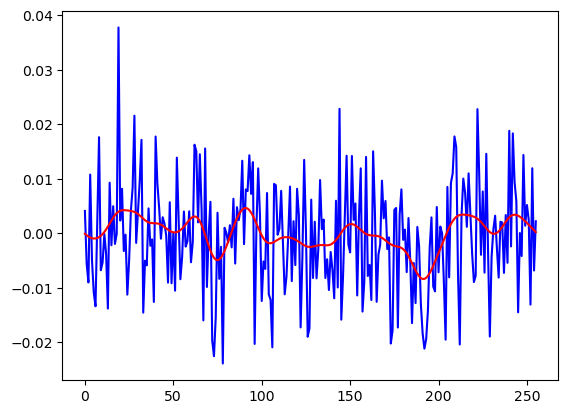

In [40]:
sigk = 50.0
    
    
ini_d,pkval = ini_del(dom,N,pk,sigk)

    
#x_i,f_i = ini_psiFromdel(ini_d,omega_m0,ai)
x_i,f_i = ini_psiVfrompsi("/Users/rajvanmp/station_X/pyGP_fields/psi_ini.npy",omega_m0,ai)
x_b,f_b = get_prd_on_ini(2000,x_i,f_i)

print(x_i.shape,x_i.shape,f_i.shape,f_b.shape)

x_bndry = tf.concat((x_i,x_b),axis=0)
f_bndry = tf.concat((f_i,f_b),axis=0)



#x_dom = tf.stack((t,x),axis=1)
#x_dom = dom.sample_domain(4000)
f_bndry_max = tf.reduce_max(f_bndry,axis=0)+tf.constant([0.0,1.0,0.0],dtype=DTYPE)

f_bndry_min = tf.reduce_min(f_bndry,axis=0)

f_bndry_norm = 2.0*(f_bndry-f_bndry_min)/(f_bndry_max-f_bndry_min)-1.0

#out_scales = [f_bndry_min,f_bndry_max]
with open('4x100_s50_outscales.pkl', 'rb') as f:
    out_scales = pickle.load(f)
print("Out,",out_scales)
    
omg =  np.array([omega_m0])#np.array([0.01/np.pi])##

sp = SP1(dom_bnds,out_scales,3,omg,DTYPE)
sp.model = sp.make_model(4,no_of_neu=100,act="tanh")
    #sp.model.summary()
    
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([10000,15000,25000],[1e-3,1e-4,5e-5,1e-5])
#lr = 0.001
# Choose the optimizer
optim1 = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
sp.ready_model(optim1)

    #sp.model.compile(loss="mse",optimizer=optim1)
    
    #h=sp.model.fit(x_bndry,f_bndry_norm,epochs=1,verbose=0)
    
losses,best_params = sp.train(x_dom,x_bndry,f_bndry_norm,x_prd ,n_epochs =10000)

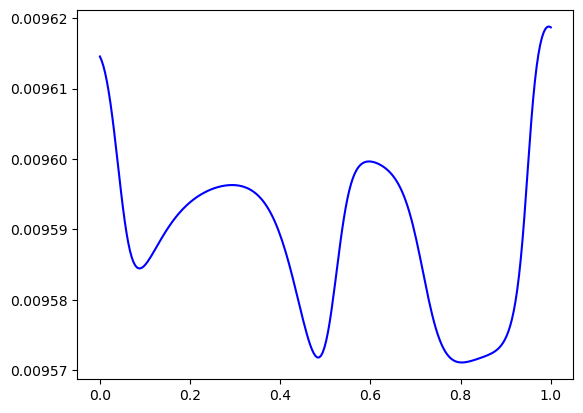

In [48]:
#sp.model.load_weights("sp1d_4x100_s50.keras")
sp.model.set_weights(best_params)
prdi = sp.model(x_i)
prdi = 0.5*(prdi+1.0)*(sp.fmax-sp.fmin) + sp.fmin
prdi = 0.5*(prdi+1.0)*(sp.fmax-sp.fmin) + sp.fmin
prdisqr = tf.square(prdi[:,0])+tf.square(prdi[:,1])
deli = prdisqr-tf.reduce_mean(prdisqr)
#plt.plot(x_i[:,1],f_i[:,0]*f_i[:,0]/0.9-1.0,"r")
plt.plot(x_i[:,1],prdi[:,0]*prdi[:,0]/0.9-1.0,"b")
#plt.plot(x_i[:,1],prdi[:,0],"b")

In [42]:
losses2,best_params2 = sp.train(x_dom,x_bndry,f_bndry_norm,x_prd ,n_epochs =10000)

It 00000: loss = 4.65931216e-03  diff_2_loss = 0.05538722962101158
It 00050: loss = 4.64636212e-03  diff_2_loss = 0.05642189497211441
It 00100: loss = 4.61392614e-03  diff_2_loss = 0.053699787169534455
It 00150: loss = 4.60353276e-03  diff_2_loss = 0.0536411812930033
It 00200: loss = 4.59337816e-03  diff_2_loss = 0.05366862277342128
It 00250: loss = 4.58319807e-03  diff_2_loss = 0.05370094117169755
It 00300: loss = 4.57293934e-03  diff_2_loss = 0.053732011371341516
It 00350: loss = 4.56256960e-03  diff_2_loss = 0.05376157745841906
It 00400: loss = 4.55206523e-03  diff_2_loss = 0.05378937227188387
It 00450: loss = 4.54140755e-03  diff_2_loss = 0.05381508671283085
It 00500: loss = 4.53058093e-03  diff_2_loss = 0.05383835541777378
It 00550: loss = 4.51957182e-03  diff_2_loss = 0.053858771044959765
It 00600: loss = 4.50836813e-03  diff_2_loss = 0.053875901625634603
It 00650: loss = 4.49695884e-03  diff_2_loss = 0.05388930196092347
It 00700: loss = 4.48533372e-03  diff_2_loss = 0.0538985203

It 06150: loss = 2.33624721e-03  diff_2_loss = 0.08773543359524685
It 06200: loss = 2.32360945e-03  diff_2_loss = 0.08802548972575808
It 06250: loss = 2.31086593e-03  diff_2_loss = 0.0883030951534355
It 06300: loss = 2.30066670e-03  diff_2_loss = 0.0885171770740875
It 06350: loss = 2.28793903e-03  diff_2_loss = 0.08883520766490861
It 06400: loss = 2.27659052e-03  diff_2_loss = 0.08908641982601806
It 06450: loss = 2.26514708e-03  diff_2_loss = 0.089332474357867
It 06500: loss = 2.25360086e-03  diff_2_loss = 0.08956783786981984
It 06550: loss = 2.24197239e-03  diff_2_loss = 0.08982047315908397
It 06600: loss = 2.23138966e-03  diff_2_loss = 0.090068183156289
It 06650: loss = 2.21949534e-03  diff_2_loss = 0.09024456688978157
It 06700: loss = 2.20821825e-03  diff_2_loss = 0.09044675490545466
It 06750: loss = 2.19684762e-03  diff_2_loss = 0.09064128673094504
It 06800: loss = 2.24574202e-03  diff_2_loss = 0.08832553552357238
It 06850: loss = 2.17485931e-03  diff_2_loss = 0.09102270367450582
I

(256, 3)
deli shape  (256,)


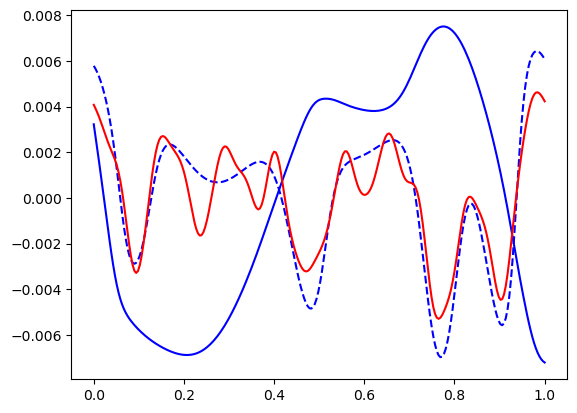

In [49]:
#sp.model.load_weights("sp1d_4x100_s50.keras")
sp.model.set_weights(best_params2)
prdi = sp.model(x_i)
print(prdi.shape)
prdi = 0.5*(prdi+1.0)*(sp.fmax-sp.fmin) + sp.fmin
prdisqr = tf.square(prdi[:,0])+tf.square(prdi[:,1])
deli_late = prdisqr-tf.reduce_mean(prdisqr)
deliact = tf.square(f_i[:,0])+tf.square(f_i[:,1])
deliact = deliact-tf.reduce_mean(deliact)
print("deli shape ",deli.shape)
#plt.plot(x_i[:,1],f_i[:,0]*f_i[:,0]/0.9-1.0,"r")
plt.plot(x_i[:,1],deli,"b")
plt.plot(x_i[:,1],deli_late,"b--")
plt.plot(x_i[:,1],deliact,"r")

#plt.plot(x_i[:,1],prdi[:,0],"b")

(1024, 2)
(1024, 2)


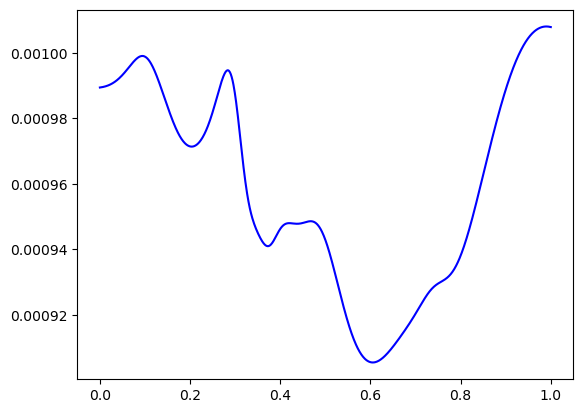

In [90]:
N=1024
x = tf.linspace(dom.lwb[1],dom.upb[1],N)
ti = ai*tf.ones_like(x)
di = tf.stack((ti,x),axis=-1)
print(di.shape)
prdi = sp.model(di)
prdi = 0.5*(prdi+1.0)*(sp.fmax-sp.fmin) + sp.fmin
dli = (tf.square(prdi[:,0]))/(3.0*omega_m0)  - 1.0


af = tf.ones_like(x)
df = tf.stack((af,x),axis=-1)
print(df.shape)
prdf = sp.model(df)
prdf = 0.5*(prdf+1.0)*(sp.fmax-sp.fmin) + sp.fmin
dlf = (tf.square(prdf[:,0])+tf.square(prdf[:,1]))/(3.0*omega_m0) - 1.0

#ini_d,pkval = ini_del(dom,N,pk,sigk)

plt.plot(x,dlf,"b")
#plt.plot(x,dli,"r")
#plt.plot(x,ini_d,"r")
#plt.plot(x)

#plt.plot(x_i[:,0])
#plt.plot(di[:,0])

In [52]:
tot_epochs=29999
ep_num=5
ep_list = []
dp = int(tot_epochs/ep_num)
for i in range(ep_num):
        ep_list.append((i+1)*dp)
print(ep_list,dp)

[5999, 11998, 17997, 23996, 29995] 5999


In [83]:
def run_case(sig,each_subepoch=10000,ep_num=5):

    
        
        
    fpini_name = "psi_ini_"+str(sig) 
    address_ini = "/Users/rajvanmp/station_X/pyGP_fields/"+fpini_name+".npy"
    addess_case = "/Users/rajvanmp/station_X/pyGP_fields/TF_PINNs/case"+str(sig)
    
    if not os.path.isdir(addess_case):
        os.mkdir(addess_case)
    
    x_i,f_i = ini_psiVfrompsi(address_ini,omega_m0,ai)
    x_b,f_b = get_prd_on_ini(2000,x_i,f_i)

    print(x_i.shape,x_i.shape,f_i.shape,f_b.shape)

    x_bndry = tf.concat((x_i,x_b),axis=0)
    f_bndry = tf.concat((f_i,f_b),axis=0)



    #x_dom = tf.stack((t,x),axis=1)
    #x_dom = dom.sample_domain(4000)
    f_bndry_max = tf.reduce_max(f_bndry,axis=0)+tf.constant([0.0,1.0,0.0],dtype=DTYPE)

    f_bndry_min = tf.reduce_min(f_bndry,axis=0)

    f_bndry_norm = 2.0*(f_bndry-f_bndry_min)/(f_bndry_max-f_bndry_min)-1.0

    out_scales = [f_bndry_min,f_bndry_max]
    #with open('4x100_s50_outscales.pkl', 'rb') as f:
    #    out_scales = pickle.load(f)
    print("Out,",out_scales)
    
    omg =  np.array([omega_m0])#np.array([0.01/np.pi])##

    sp = SP1(dom_bnds,out_scales,3,omg,DTYPE)
    sp.model = sp.make_model(4,no_of_neu=100,act="tanh")
    #sp.model.summary()
    
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([10000,15000,25000],[1e-3,1e-4,5e-5,1e-5])
    #lr = 0.001
    # Choose the optimizer
    optim1 = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    sp.ready_model(optim1)

    #sp.model.compile(loss="mse",optimizer=optim1)
    
    #h=sp.model.fit(x_bndry,f_bndry_norm,epochs=1,verbose=0)
    
    best_params=[]
    
    epochs_done=0
    losses=[]
    for i in range(ep_num):
        epochs_done = each_subepoch+epochs_done
        losses,best_params_c = sp.train(x_dom,x_bndry,f_bndry_norm,x_prd ,n_epochs =each_subepoch)
        losses=losses+losses
        sp.model.set_weights(best_params_c)
        modelsave_name = "best_param_"+str(epochs_done)+".keras"
        modelsave_path = os.path.join(addess_case,modelsave_name)
        sp.model.save_weights(modelsave_path)
        #best_params.append(best_params_c)
    
   
    lossnamesave = os.path.join(addess_case,"losses.npy")
    np.save(lossnamesave,np.array(losses))

In [84]:
import os as os

In [85]:
for i in range(1,6):
        sigmak = i*50.0
        run_case(sigmak,each_subepoch=2,ep_num=2)

/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_25972/686935307.py:61: RuntimeWarning: divide by zero encountered in divide
  vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_25972/686935307.py:61: RuntimeWarning: invalid value encountered in divide
  vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2


(256,) (256,) (256,) (256, 3)
nby2 1000
(2000,) (2000, 2)
(256, 2) (256, 2) (256, 3) (2000, 3)
Out, [<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 0.9460851 ,  0.        , -0.29432967])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.95106378, 1.        , 0.23821691])>]
Prob coef tf.Tensor(0.3, shape=(), dtype=float64)
Bounds tf.Tensor([0.0078125 0.       ], shape=(2,), dtype=float64) tf.Tensor([1. 1.], shape=(2,), dtype=float64)
It 00000: loss = 7.49888846e-01  diff_2_loss = 0.058505884769291513
Best loss is  tf.Tensor(0.47837392571751713, shape=(), dtype=float64)
It 00000: loss = 3.54277189e-01  diff_2_loss = 0.13983089839002563
Best loss is  tf.Tensor(0.31962190117436673, shape=(), dtype=float64)
(256,) (256,) (256,) (256, 3)
nby2 1000
(2000,) (2000, 2)
(256, 2) (256, 2) (256, 3) (2000, 3)
Out, [<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 0.94512897,  0.        , -0.45121143])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.95107025, 1.        , 0.479

In [17]:
print(nout)
print(out_scales)

[<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 0.94627528,  0.        , -1.67556379])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.95341491, 1.        , 1.16974791])>]
[<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 0.94627528,  0.        , -1.67556379])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.95341491, 1.        , 1.16974791])>]
